In [80]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import numpy as np
import datetime

import settings

from depth_estimator.midas import midas_estimator
from depth_estimator.glpn import glpn_model

In [87]:
def model_evaluate(mod_name, estimator):

    mae_df = pd.DataFrame(
        columns = ['photo_name', 'model', 'MAE', 'run-time (sec)'],
        
    )
    j = 0
    for i in range(9):
        
        params = []
        params.append(i)
        params.append(mod_name)
        image = estimator.image_prepare(
            os.path.join(
                settings.PHOTO_DIR, f"{i}_rgb.png"
            )
        )
        img_true_depth = np.array(
            Image.open(
                os.path.join(
                    settings.PHOTO_DIR, 
                    f"{i}_depth.png"
                )
            )
        )
        true_depth = img_true_depth.reshape(1,-1)[0]
        start = datetime.datetime.now()
        depth = np.array(estimator.predict_depth(image)).reshape(1,-1)[0][0]
        end = datetime.datetime.now()

        time_delta = (end-start).microseconds/1000000
        MAE = (sum(abs((true_depth-depth)))/true_depth.shape[0]).round(2)
        params.append(MAE)

        params.append(time_delta)

        mae_df.loc[j] = params

        j+=1

    return mae_df, mae_df.drop('photo_name',axis=1).groupby(by='model').mean()

### Our goal in models testing was to evaluete how accurately they can predict depth of common domestick objects

In this way we used RGBD dataset was found [here](https://www.kaggle.com/datasets/metagrasp/metagraspnetdifficulty1-easy)

Our metric was MAE and we compared model`s predicted depth with true object depth. Moreover we evaluated run-time

----

### We chose from three models. [Midas](https://pytorch.org/hub/intelisl_midas_v2/) Large/Small and [glpn](https://github.com/arminmasoumian/gcndepth)

In [3]:
list_dir = os.listdir(settings.PHOTO_DIR)

In [75]:
model_midas = ["DPT_Large", "MiDaS_small"]

In [ ]:
mod_name = model_midas[0]

torch.cuda.empty_cache()
estimator = midas_estimator(
    mod_name,
    settings.DEVICE,
)

In [70]:
mae_df, model_grouped_eval = model_evaluate(mod_name, estimator)

In [76]:
mod_name = model_midas[1]

torch.cuda.empty_cache()
estimator = midas_estimator(
    mod_name,
    settings.DEVICE,
)

Using cache found in C:\Users\mirad/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


d:\Programming\python-38\lib\site-packages\torch\hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to C:\Users\mirad/.cache\torch\hub\master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to C:\Users\mirad/.cache\torch\hub\checkpoints\tf_efficientnet_lite3-b733e338.pth
Download

  0%|          | 0.00/81.8M [00:00<?, ?B/s]

Using cache found in C:\Users\mirad/.cache\torch\hub\intel-isl_MiDaS_master


In [77]:
mae_df1, model_grouped_eval1 = model_evaluate(mod_name, estimator)

In [83]:
mod_name = 'glpn'

torch.cuda.empty_cache()
estimator = glpn_model(
    settings.DEPTH_ESTIMATOR_WEIGHTS_PATH
)

In [88]:
mae_df3, model_grouped_eval3 = model_evaluate(mod_name, estimator)

In [91]:
mae_df_all = pd.concat([mae_df, mae_df1, mae_df3])

In [92]:
mae_df_all

,photo_name,model,MAE,run-time (sec)
0,0,DPT_Large,62.28,0.728810
1,1,DPT_Large,123.02,0.551458
2,2,DPT_Large,111.97,0.575197
3,3,DPT_Large,122.65,0.557782
4,4,DPT_Large,111.37,0.569186
5,5,DPT_Large,116.99,0.566448
6,6,DPT_Large,111.79,0.558274
7,7,DPT_Large,122.68,0.552736
8,8,DPT_Large,111.23,0.559168
0,0,MiDaS_small,200.15,0.258206


In [93]:
model_grouped_eval_all = pd.concat([model_grouped_eval, model_grouped_eval1, model_grouped_eval3])

In [94]:
model_grouped_eval_all

,MAE,run-time (sec)
model,,
DPT_Large,110.442222,0.579895
MiDaS_small,242.297778,0.060076
glpn,126.356667,0.107492


### After tests we can took DPT_Large or glpn... But DPT_Large's estimation looks better.

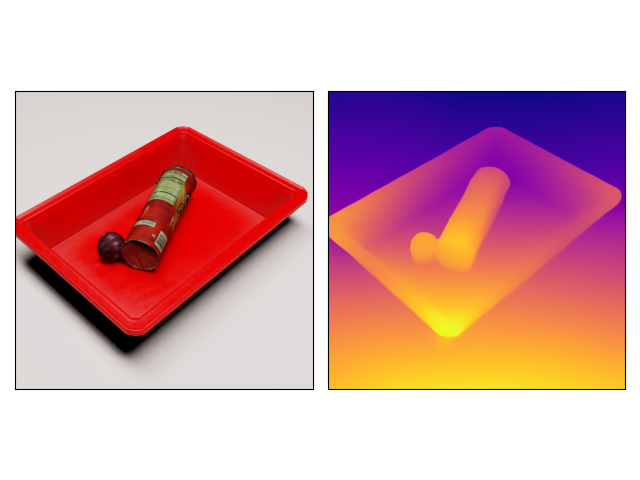

In [96]:
Image.open('test/depth_predicted/2_rgb.png')